<a href="https://colab.research.google.com/github/wendycao411/Pedestrian_Tracking/blob/main/Pedestrian_Tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pedestrian Tracking

created by wendycao 2025/1

best if run with T4 GPU (A100 GPU if Colab Pro)! it'll be much faster. to change GPU, go to the runtime tab and select "change runtime type".

#### When running in Google Colab:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Installing dependencies

In [1]:
%pip install opencv-python
%pip install pandas
%pip install numpy
%pip install ultralytics
%pip install roboflow
%pip install matplotlib
%pip install os-sys
%pip install roboflow
%pip install inference_sdk
%pip install easydict

%pip install lap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.9/914.9 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 19.6 MB/s eta 0:00:00


In [ ]:
%pip uninstall numpy -y
%pip install "numpy<1.24"

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
Traceback (most recent call last):
  File "/usr/lib/python3.11/shutil.py", line 853, in move
    os.rename(src, real_dst)
OSError: [Errno 18] Invalid cross-device link: '/usr/local/lib/python3.11/dist-packages/numpy/' -> '/usr/local/lib/python3.11/dist-packages/~umpy'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/uninstall.py", line 106, in run
    uninstall_pathset = req.uninstall(
                        ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/req/req_install.py", line 722, in uninstall
    uninstalled_pathset.remove(auto_confirm, verbose)
  File "/usr/local/lib/python3.11/dist-pa

In [ ]:
import cv2
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from PIL import Image, ImageDraw
from inference_sdk import InferenceHTTPClient

from collections import defaultdict

from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator, colors

from roboflow import Roboflow

from IPython.display import Image, display

import torch

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

(if it asks to restart the runtime, click restart session and then re-run the cell importing modules)

#### Download Videos from Google Drive (requires the download link)

*How to generate the download link:*


1.   Get the "Share Link" for the video (make sure anyone can view the video!) - e.g. https://drive.google.com/file/d/1CNjE7CWTuyqgm-zTRGk5qIxSDG8A7P7q/view?usp=drive_link
2.   Get the ID for the video, which is in between the /d/ and /view - e.g. 1CNjE7CWTuyqgm-zTRGk5qIxSDG8A7P7q
3.   Paste the ID in this link: https://drive.google.com/uc?id=(ID HERE)&export=download -- e.g. https://drive.google.com/uc?id=1CNjE7CWTuyqgm-zTRGk5qIxSDG8A7P7q&export=download
4.   Done!



In [ ]:
!gdown https://drive.google.com/uc?id=1ebJKFg61mLB2rnHi5AsguYse19uMarHw&export=download

Downloading...
From (original): https://drive.google.com/uc?id=1BCpTCn1fSh4eC7q-HeT0p9xF2I_FoKMq
From (redirected): https://drive.google.com/uc?id=1BCpTCn1fSh4eC7q-HeT0p9xF2I_FoKMq&confirm=t&uuid=39f09f18-b996-49e4-aad6-7a66da0f59f0
To: /content/2023-07-16.mp4
100% 2.82G/2.82G [00:11<00:00, 244MB/s]


#### Preprocessing

In [ ]:
video_path = "/content/2022-08-27.mp4"
file_name = os.path.splitext(os.path.basename(video_path))[0]

print(file_name)

2023-07-16


In [ ]:
# video preprocessing

# option 1 Adjust the frame rate to 5 FPS, and the total duration remains unchanged
!ffmpeg -i "/content/2022-08-27.mp4" -r 5 "/content/2022-08-27_5fps.mp4"


# NOT WORKING YET!!
# # option 2 function: subsample/time lapse video
# def subsample_video(input_path, output_path, time_lapse_interval):
#     cap = cv2.VideoCapture(input_path)
#     if not cap.isOpened():
#         print("Error: Couldn't open video file.")
#         return

#     frame_count = 0
#     fps = cap.get(cv2.CAP_PROP_FPS)
#     width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
#     height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
#     codec = cv2.VideoWriter_fourcc(*'XVID')
#     out = cv2.VideoWriter(output_path, codec, fps, (width, height))

#     while cap.isOpened():
#         ret, frame = cap.read()
#         if not ret:
#             break

#         # Collect one frame out of every xx frames
#         if frame_count % time_lapse_interval == 0:
#             out.write(frame)

#         frame_count += 1

#     cap.release()
#     out.release()
#     #cv2.destroyAllWindows()

# if __name__ == "__main__":
#     time_lapse_interval = 5 # change here
#     input_file = video_path
#     output_file = f"/content/Pedestrian_Tracking/timelapsed/{file_name}_timelapsed{time_lapse_interval}.mp4"  # Replace with desired output video file path
#     subsample_video(input_file, output_file, time_lapse_interval)
#     print(f"saved to {output_file}")

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [ ]:
video_path = "/content/2023-07-16_5fps.mp4"
file_name = os.path.splitext(os.path.basename(video_path))[0]

print(video_path)
print(file_name)

/content/2023-07-16_5fps.mp4
2023-07-16_5fps


In [ ]:
# number of frames in the video
cap = cv2.VideoCapture(video_path)

# Get the file name
file_name = os.path.splitext(os.path.basename(video_path))[0]

# Get the total number of frames of the video
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
original_fps = cap.get(cv2.CAP_PROP_FPS)

print(f"The total number of frames in the video：{total_frames}\nVideo frame rate：{original_fps}")
cap.release()

The total number of frames in the video：5437
Video frame rate：5.0


#### Download the Model!

can also download elsewhere and upload to get other models and test if they are better

In [ ]:
#!gdown https://drive.google.com/uc?id=19ZYplT-m0SaXrJXks9DhO7wdIUMpK2_F&export=download

#used by Emma, not tested if more accurate yet but is slower
#!gdown https://drive.google.com/uc?id=1WFUfBKAB2_U96PwHiI08seJzKk3yeGLg&export=download

#another model to test with (the most recent and accurate?? one)
!gdown https://drive.google.com/uc?id=1ybVH-ZreQxhXzJ_MTLzMQKPOGcHpFI6S&export=download

Downloading...
From (original): https://drive.google.com/uc?id=1ybVH-ZreQxhXzJ_MTLzMQKPOGcHpFI6S
From (redirected): https://drive.google.com/uc?id=1ybVH-ZreQxhXzJ_MTLzMQKPOGcHpFI6S&confirm=t&uuid=71036523-d937-47ad-af25-0f2622ae3e5a
To: /content/yolo11x-seg.pt
100% 125M/125M [00:01<00:00, 69.6MB/s]


#### To implement the DeepSORT tracking, downloading the required files (only needs to be done once at the beginnning of running the code)

In [ ]:
!gdown "https://drive.google.com/uc?id=11ZSZcG-bcbueXZC3rN08CM0qqX3eiHxf&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=11ZSZcG-bcbueXZC3rN08CM0qqX3eiHxf&confirm=t
To: /content/deep_sort_pytorch.zip
100% 43.1M/43.1M [00:02<00:00, 20.7MB/s]


In [ ]:
!unzip 'deep_sort_pytorch.zip'

Archive:  deep_sort_pytorch.zip
  inflating: deep_sort_pytorch/.gitignore  
   creating: deep_sort_pytorch/configs/
  inflating: deep_sort_pytorch/configs/deep_sort.yaml  
   creating: deep_sort_pytorch/deep_sort/
  inflating: deep_sort_pytorch/deep_sort/__init__.py  
   creating: deep_sort_pytorch/deep_sort/__pycache__/
  inflating: deep_sort_pytorch/deep_sort/__pycache__/__init__.cpython-310.pyc  
  inflating: deep_sort_pytorch/deep_sort/__pycache__/__init__.cpython-37.pyc  
  inflating: deep_sort_pytorch/deep_sort/__pycache__/__init__.cpython-38.pyc  
  inflating: deep_sort_pytorch/deep_sort/__pycache__/deep_sort.cpython-310.pyc  
  inflating: deep_sort_pytorch/deep_sort/__pycache__/deep_sort.cpython-37.pyc  
  inflating: deep_sort_pytorch/deep_sort/__pycache__/deep_sort.cpython-38.pyc  
   creating: deep_sort_pytorch/deep_sort/deep/
 extracting: deep_sort_pytorch/deep_sort/deep/__init__.py  
   creating: deep_sort_pytorch/deep_sort/deep/__pycache__/
  inflating: deep_sort_pytorch/d

#### Run the Script for Segmentation with DeepSORT Tracking

In [ ]:
from deep_sort_pytorch.utils.parser import get_config
from deep_sort_pytorch.deep_sort import DeepSort
from collections import deque

In [ ]:
# Set parameters
skip = 2
output_dir = "output"

# Function to initialize the DeepSORT tracker
def init_tracker():
    cfg = get_config()
    cfg.merge_from_file("deep_sort_pytorch/configs/deep_sort.yaml")

    deepsort = DeepSort(cfg.DEEPSORT.REID_CKPT,
                        max_dist=cfg.DEEPSORT.MAX_DIST,
                        min_confidence=cfg.DEEPSORT.MIN_CONFIDENCE,
                        nms_max_overlap=cfg.DEEPSORT.NMS_MAX_OVERLAP,
                        max_iou_distance=cfg.DEEPSORT.MAX_IOU_DISTANCE,
                        max_age=cfg.DEEPSORT.MAX_AGE,
                        n_init=cfg.DEEPSORT.N_INIT,
                        nn_budget=cfg.DEEPSORT.NN_BUDGET,
                        use_cuda=True)
    return deepsort

# Load the YOLO model for person detection
model_person = YOLO("/content/yolo11x-seg.pt").to("cuda")  # Ensure this is your correct device

# Initialize Roboflow client for shadow detection
CLIENT = InferenceHTTPClient(api_url="https://detect.roboflow.com", api_key="MlD67rmWJeli5xzVofAy")

# Create a subfolder for each video in the output directory
video_output_dir = os.path.join(output_dir, file_name)
if not os.path.exists(video_output_dir):
    os.makedirs(video_output_dir)

output_video_path = os.path.join(video_output_dir, f"{file_name}_human-and-shade-tracking.avi")
csv_file = os.path.join(video_output_dir, f"{file_name}_detections.csv")

# Initialize the DeepSORT tracker
deepsort = init_tracker()

# Dictionary to store trails
trails = {}

# Open the video file
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

w, h, fps = (int(cap.get(x)) for x in (cv2.CAP_PROP_FRAME_WIDTH, cv2.CAP_PROP_FRAME_HEIGHT, cv2.CAP_PROP_FPS))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  # Get total frame count
out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*"MJPG"), fps, (w, h))

# Initialize CSV file with headers
csv_headers = ['frame', 'person_id', 'bottom_mid_x', 'bottom_mid_y', 'in_shadow', 'shadow_area']
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(csv_headers)

frame_count = 0
consecutive_person_id = 0
person_id_mapping = {}

while cap.isOpened():
    success, frame = cap.read()
    if not success:
        print("Video frame is empty or video processing has been successfully completed.")
        break

    frame_count += 1

    if frame_count % skip == 0:
        print(f"Processing frame {frame_count}/{total_frames}")  # Display progress

        # Get the shadow boundary of the current frame
        shadow_result = CLIENT.infer(frame, model_id="shade-detection/1")
        boundaries = []

        if 'predictions' in shadow_result:
            predictions = shadow_result['predictions']
            for prediction in predictions:
                points = prediction.get("points", [])
                if points:
                    boundary = [(int(point['x']), int(point['y'])) for point in points]
                    boundaries.append(boundary)

        annotator = Annotator(frame, line_width=2)
        people_in_shadow = 0
        people_outside_shadow = 0
        total_people = 0
        detections = []

        shade_area = 0
        # Draw the shadow polygon
        for boundary in boundaries:
            boundary_points = np.array(boundary, np.int32).reshape((-1, 1, 2))
            cv2.polylines(frame, [boundary_points], isClosed=True, color=(255, 0, 0), thickness=2)
            shade_area = cv2.contourArea(boundary_points)

        # People detection
        person_results = model_person(frame, classes=[0], conf=0.05, show=False)
        if person_results and len(person_results) > 0:
            boxes = person_results[0].boxes

            if boxes and len(boxes) > 0:
                xyxy = boxes.xyxy.cpu().numpy()
                confidences = boxes.conf.cpu().numpy()
                oids = boxes.cls.cpu().numpy()

                # Convert to the format expected by DeepSORT
                bbox_xywh = []
                for box in xyxy:
                    x1, y1, x2, y2 = box
                    xc = (x1 + x2) / 2
                    yc = (y1 + y2) / 2
                    w = x2 - x1
                    h = y2 - y1
                    bbox_xywh.append([xc, yc, w, h])

                bbox_xywh = np.array(bbox_xywh)

                # Update DeepSORT tracker with detected boxes
                outputs = deepsort.update(bbox_xywh, confidences, oids, frame)

                for output in outputs:
                    x1, y1, x2, y2, track_id, track_oid = output
                    bottom_mid_x = int((x1 + x2) // 2)
                    bottom_mid_y = int(y2)
                    in_shadow = False

                    # Map the original track_id to consecutive_person_id
                    if track_id not in person_id_mapping:
                        person_id_mapping[track_id] = consecutive_person_id
                        consecutive_person_id += 1

                    # Use the mapped consecutive_person_id
                    person_id = person_id_mapping[track_id]

                    for boundary in boundaries:
                        if cv2.pointPolygonTest(np.array(boundary, np.int32), (bottom_mid_x, bottom_mid_y), False) >= 0:
                            in_shadow = True
                            people_in_shadow += 1
                            break
                    else:
                        people_outside_shadow += 1

                    detections.append([frame_count, person_id, bottom_mid_x, bottom_mid_y, in_shadow, shade_area])
                    total_people += 1

                    # Store the position for trails
                    if track_id not in trails:
                        trails[track_id] = deque(maxlen=30)
                    trails[track_id].append((bottom_mid_x, bottom_mid_y))

                    # Draw the trails
                    for i in range(1, len(trails[track_id])):
                        if trails[track_id][i - 1] is None or trails[track_id][i] is None:
                            continue
                        cv2.line(frame, trails[track_id][i - 1], trails[track_id][i], (0, 255, 0), 2)

                    color = (0, 255, 0)  # You can use your colors function if defined
                    label = f"ID {person_id} {'in shadow' if in_shadow else 'out shadow'}"
                    annotator.box_label([x1, y1, x2, y2], label=label, color=color)
                    cv2.circle(frame, (bottom_mid_x, bottom_mid_y), 5, (0, 0, 255), -1)

        # Write the results to CSV
        with open(csv_file, 'a', newline='') as file:
            writer = csv.writer(file)
            writer.writerows(detections)

        # Display the statistics results on the frame
        text = f"Frame {frame_count}: Total: {total_people}, In Shadow: {people_in_shadow}, Outside Shadow: {people_outside_shadow}"
        cv2.putText(frame, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

        # Write the original frame
        out.write(frame)

        #COMMENT OUT IF ON COLAB, but can display progress
        #cv2_imshow("instance-segmentation-object-tracking", frame)  # Display the frame using cv2_imshow
        #if cv2.waitKey(1) & 0xFF == ord("q"):
        #    break

cap.release()
out.release()

print(f"Processing complete. Results saved in {output_video_path} and {csv_file}.")

Processing frame 2/5437

0: 384x640 19 persons, 81.8ms
Speed: 2.2ms preprocess, 81.8ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)
Processing frame 4/5437

0: 384x640 18 persons, 41.5ms
Speed: 2.5ms preprocess, 41.5ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)
Processing frame 6/5437

0: 384x640 19 persons, 41.6ms
Speed: 2.5ms preprocess, 41.6ms inference, 2.3ms postprocess per image at shape (1, 3, 384, 640)
Processing frame 8/5437

0: 384x640 17 persons, 75.7ms
Speed: 2.4ms preprocess, 75.7ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)
Processing frame 10/5437

0: 384x640 16 persons, 66.1ms
Speed: 2.5ms preprocess, 66.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)
Processing frame 12/5437

0: 384x640 16 persons, 80.9ms
Speed: 2.7ms preprocess, 80.9ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)
Processing frame 14/5437

0: 384x640 14 persons, 69.8ms
Speed: 2.4ms preprocess, 69.8m

# Data Analysis

#### Creating a document to store all graphs

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

csv_dir = os.path.dirname(csv_file)

# Create a PDF document
pdf_file = os.path.join(csv_dir, "all_plots.pdf")
pdf = PdfPages(pdf_file)

#### Count of People

      Frame  in_shadow  out_shadow
0         0          0           0
1         1          0           0
2         2          0           0
3         3          0           0
4         4          0           0
...     ...        ...         ...
2885   2885          0           0
2886   2886          1          14
2887   2887          0           0
2888   2888          1          13
2889   2889          0           0

[2890 rows x 3 columns]


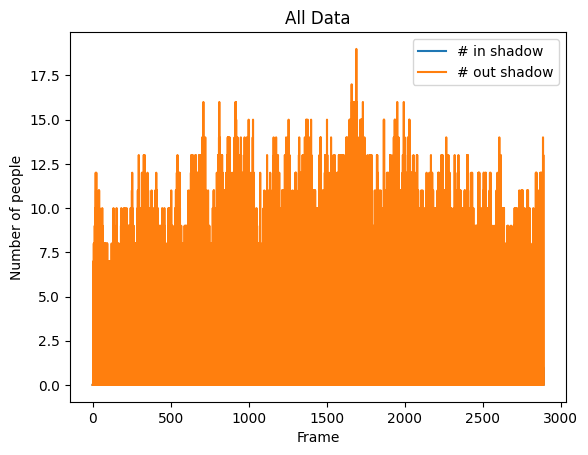

In [ ]:
import pandas as pd

data = pd.read_csv(csv_file)
num_in_shadow = {}
num_out_shadow = {}

for i in range(data['frame'].nunique()):
  count = len(data[(data['in_shadow'] == True) & (data['frame'] == i)])
  num_in_shadow[i] = count
  count = len(data[(data['in_shadow'] == False) & (data['frame'] == i)])
  num_out_shadow[i] = count

df = pd.DataFrame([num_in_shadow, num_out_shadow]).T
df.columns = ['in_shadow', 'out_shadow']
df.reset_index(inplace=True)

# Optional: Rename the index column
df.rename(columns={'index': 'Frame'}, inplace=True)

print(df)

fig, ax = plt.subplots()
ax.plot(df['Frame'], df['in_shadow'], label='# in shadow')
ax.plot(df['Frame'], df['out_shadow'], label='# out shadow')
ax.legend()

ax.set_xlabel('Frame')
ax.set_ylabel('Number of people')
plt.title("All Data")

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)

#### Moving Average

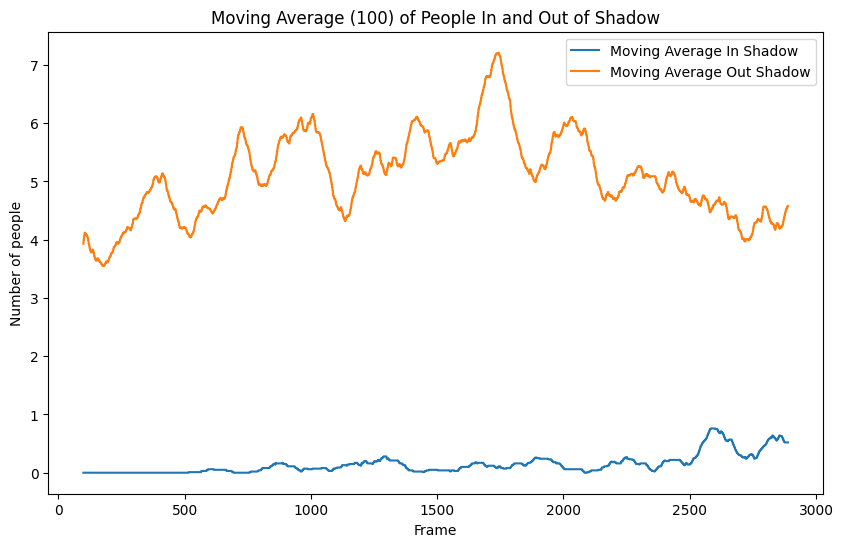

In [ ]:
# Calculate the moving average for 'out_shadow'
#edit window
df['ma_out_shadow'] = df['out_shadow'].rolling(window=100).mean()

df['ma_in_shadow'] = df['in_shadow'].rolling(window=100).mean()

# Plot the moving averages
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df['Frame'], df['ma_in_shadow'], label='Moving Average In Shadow')
ax.plot(df['Frame'], df['ma_out_shadow'], label='Moving Average Out Shadow')
ax.legend()
ax.set_xlabel('Frame')
ax.set_ylabel('Number of people')
ax.set_title('Moving Average (100) of People In and Out of Shadow')

# Save the current plot to the PDF
pdf.savefig(fig)
plt.show()
plt.close(fig)

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




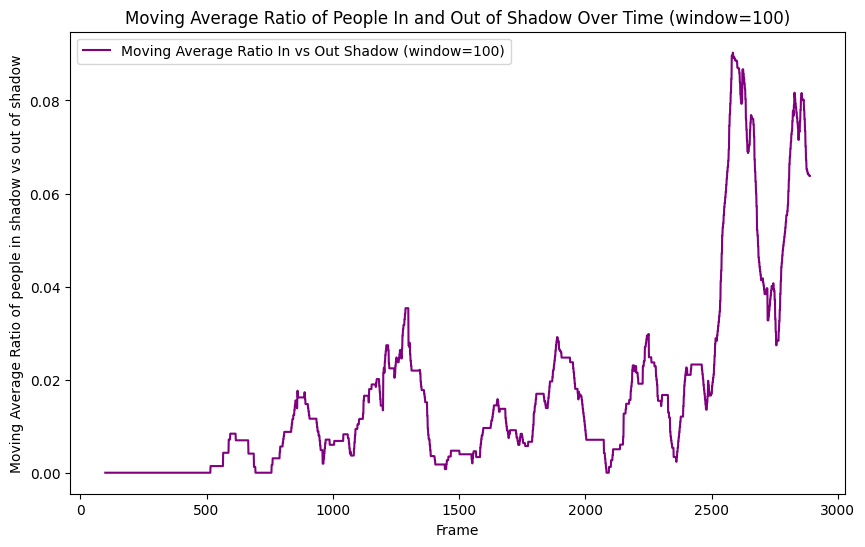

In [ ]:
# Calculate the ratio of people in shade vs. out of shade
df['ratio_in_vs_out'] = df['in_shadow'] / df['out_shadow']

# Replace NaN and infinite values with zeros (or another value if appropriate)
df['ratio_in_vs_out'].replace([np.inf, -np.inf], np.nan, inplace=True)
df['ratio_in_vs_out'] = df['ratio_in_vs_out'].fillna(0)

# Calculate the moving average for the ratio
window_size = 100
df['ma_ratio_in_vs_out'] = df['ratio_in_vs_out'].rolling(window=window_size).mean()

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df['Frame'], df['ma_ratio_in_vs_out'], label=f'Moving Average Ratio In vs Out Shadow (window={window_size})', color='purple')
ax.set_xlabel('Frame')
ax.set_ylabel('Moving Average Ratio of people in shadow vs out of shadow')
ax.set_title(f'Moving Average Ratio of People In and Out of Shadow Over Time (window={window_size})')
ax.legend()

# Save the current plot to the PDF
pdf.savefig(fig)
plt.show()
plt.close(fig)

#### Shade Evolution

Shade data saved to output/2024-07-03_5fps/shade_area.csv


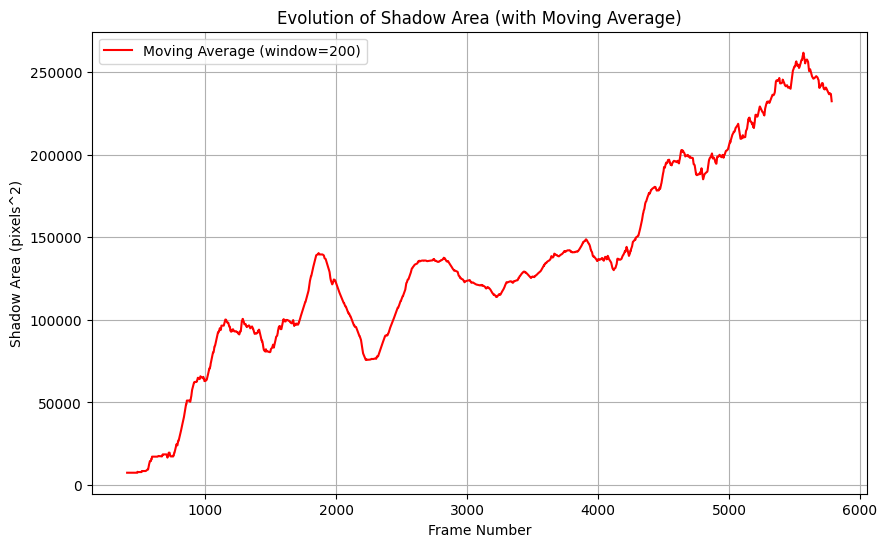

In [ ]:
# Extract the 'frame' and 'shade_area' columns
data = data[['frame', 'shadow_area']]

# Remove duplicate rows
data = data.drop_duplicates()

# Sort the data by 'frame' to ensure the plot is in the correct order
data = data.sort_values(by='frame')

# Calculate the moving average with a window size of your choice (e.g., 5 frames)
window_size = 200
data['shadow_area_moving_avg'] = data['shadow_area'].rolling(window=window_size).mean()

output_dir = "output"
video_output_dir = os.path.join(output_dir, file_name)
if not os.path.exists(video_output_dir):
    os.makedirs(video_output_dir)

# Save the filtered data to a new CSV file in the subfolder
shade_area_file = os.path.join(video_output_dir, 'shade_area.csv')
data.to_csv(shade_area_file, index=False)

print(f"Shade data saved to {shade_area_file}")

# Plot the original shade area and its moving average
fig, ax = plt.subplots(figsize=(10, 6))
#ax.plot(data['frame'], data['shadow_area'], marker='o', linestyle='-', color='b', label='Shade Area')
ax.plot(data['frame'], data['shadow_area_moving_avg'], marker='', linestyle='-', color='r', label=f'Moving Average (window={window_size})')
ax.set_xlabel('Frame Number')
ax.set_ylabel('Shadow Area (pixels^2)')
ax.set_title('Evolution of Shadow Area (with Moving Average)')
ax.legend()
ax.grid(True)

# Save the current plot to the PDF
pdf.savefig(fig)
plt.show()
plt.close(fig)

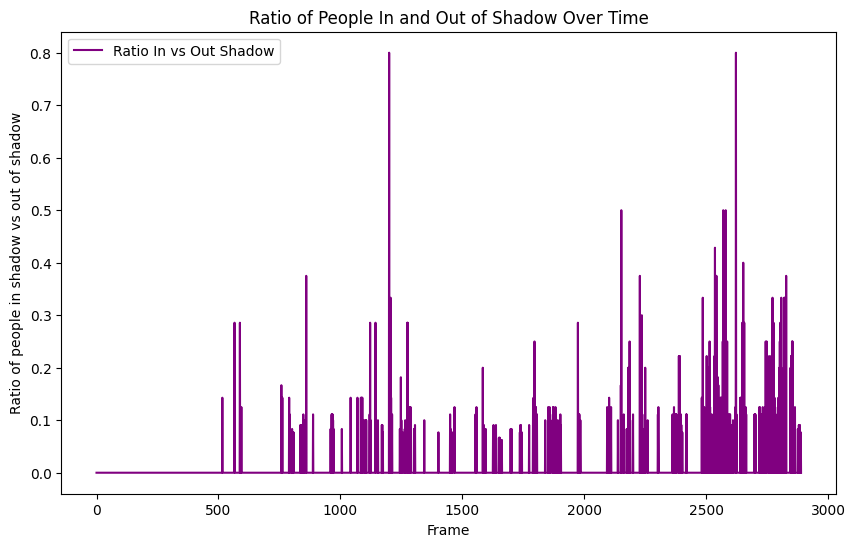

In [ ]:
# Calculate the ratio of people in shade vs. out of shade
df['ratio_in_vs_out'] = df['in_shadow'] / df['out_shadow']

# Replace NaN values with zeros (or another value if appropriate)
df['ratio_in_vs_out'] = df['ratio_in_vs_out'].fillna(0)

# Plot the ratio
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df['Frame'], df['ratio_in_vs_out'], label='Ratio In vs Out Shadow', color='purple')
ax.set_xlabel('Frame')
ax.set_ylabel('Ratio of people in shadow vs out of shadow')
ax.set_title('Ratio of People In and Out of Shadow Over Time')
ax.legend()

# Save the current plot to the PDF
pdf.savefig(fig)
plt.show()
plt.close(fig)

#### Homography Transformation

Download image of streetview to transform

In [ ]:
!gdown https://drive.google.com/uc?id=1ZD0bqEYLhLWE_3UwF1jyw-xSZ2FAO7eV&export=download

Downloading...
From: https://drive.google.com/uc?id=1ZD0bqEYLhLWE_3UwF1jyw-xSZ2FAO7eV
To: /content/image.png
100% 1.92M/1.92M [00:00<00:00, 133MB/s]


In [ ]:
# Image coordinates (in pixels)
image_points = np.array([
    [1149,339 ],
    [1337, 363],
    [42, 666],
    [1332, 787]
], dtype='float32')

# Corresponding geocoordinates (latitude, longitude)
geo_src_pts = np.array([
    (35.69381792666122, 139.70106477073716),  # Point 1 (top-left)
    (35.69384210019835, 139.70098082588615),  # Point 2 (top-right)
    (35.6941991886913, 139.70120388071484),  # Point 3 (bottom-left)
    (35.69415186953212, 139.70107569864496)   # Point 4 (bottom-right)
])

In [ ]:
from scipy.interpolate import griddata

# Calculate the transformation matrix for latitude and longitude
def calculate_geocoordinates(image_points, geo_points, x, y):
    # Separate latitude and longitude from geo_points
    latitudes = geo_points[:, 0]
    longitudes = geo_points[:, 1]

    # Interpolate the latitude and longitude for the given x, y coordinates
    latitude = griddata(image_points, latitudes, (x, y), method='linear')
    if np.isnan(latitude):
        latitude = griddata(image_points, latitudes, (x, y), method='nearest')

    longitude = griddata(image_points, longitudes, (x, y), method='linear')
    if np.isnan(longitude):
        longitude = griddata(image_points, longitudes, (x, y), method='nearest')

    return latitude, longitude

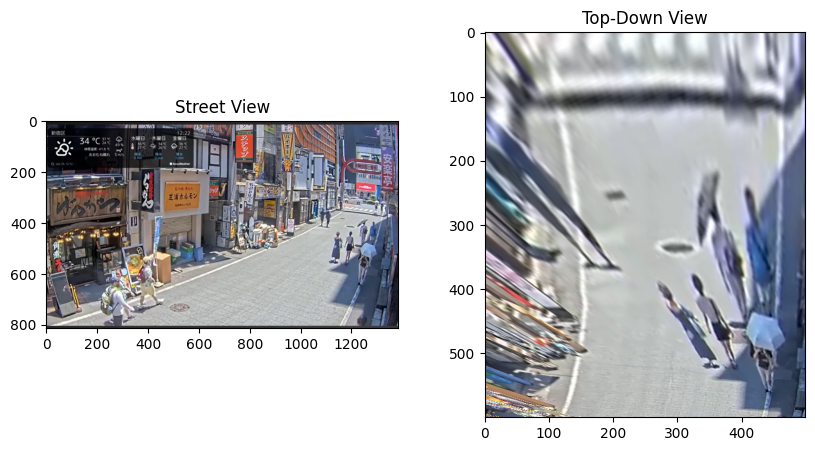

In [ ]:
# Load the street view image
street_view_image = cv2.imread('image.png')

# Define the corresponding points on the top-down view (in pixel coordinates)
dst_pts = np.array([
    [0, 0],
    [500, 0],
    [0, 600],
    [500, 600]
], dtype='float32')

# Calculate the homography matrix
H, _ = cv2.findHomography(image_points, dst_pts)

# Apply the homography transformation
top_down_view = cv2.warpPerspective(street_view_image, H, (500, 600))

# Display the original and transformed images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Street View')
plt.imshow(cv2.cvtColor(street_view_image, cv2.COLOR_BGR2RGB))

plt.subplot(1, 2, 2)
plt.title('Top-Down View')
plt.imshow(cv2.cvtColor(top_down_view, cv2.COLOR_BGR2RGB))

plt.show()

In [ ]:
# Load the csv
data = pd.read_csv(csv_file)

def apply_homography(x, y, H):
    # Convert to homogeneous coordinates
    point = np.array([x, y, 1.0])
    transformed_point = H @ point

    # Convert back to Cartesian coordinates
    transformed_point /= transformed_point[2]
    return transformed_point[0], transformed_point[1]

# Apply the homography transformation to each coordinate in the data
transformed_coords = data.apply(
    lambda row: apply_homography(row['bottom_mid_x'], row['bottom_mid_y'], H), axis=1
)

# Split the transformed coordinates into separate columns
data['transformed_x'] = transformed_coords.apply(lambda coord: coord[0])
data['transformed_y'] = transformed_coords.apply(lambda coord: coord[1])

# Calculate the geocoordinates for each transformed point
geo_coords = data.apply(
    lambda row: calculate_geocoordinates(image_points, geo_src_pts, row['transformed_x'], row['transformed_y']), axis=1
)

# Split the geocoordinates into separate columns
data['latitude'] = geo_coords.apply(lambda coord: coord[0])
data['longitude'] = geo_coords.apply(lambda coord: coord[1])

# Save the transformed coordinates and geocoordinates to a new CSV file
transformed_output_file = os.path.join(video_output_dir, 'transformed_detections.csv')
data.to_csv(transformed_output_file, index=False)

print(f"Transformed data with geocoordinates saved to {transformed_output_file}")

Transformed data with geocoordinates saved to output/2024-07-03_5fps/transformed_detections.csv


#### Filter

In [ ]:
# Load the csv
data = pd.read_csv(transformed_output_file)

# Define the minimum presence duration (in frames) to consider a track segment as valid
MIN_PRESENCE_DURATION = 30  # Adjust this based on your needs

# Define the maximum allowed displacement (in pixels)
MAX_DISPLACEMENT = 50  # Adjust this threshold based on your needs

# Define the maximum gap between frames to consider a continuous segment
MAX_FRAME_GAP = 100  # Adjust this threshold based on your needs

# Function to process each group
def process_group(x):
    # Extract the list of tuples
    coordinates_and_shadow = list(zip(x['frame'], x['bottom_mid_x'], x['bottom_mid_y'], x['in_shadow']))
    coordinates_and_shadow.sort(key=lambda t: t[0])

    transformed_coordinates_and_shadow = list(zip(x['frame'], x['transformed_x'], x['transformed_y'], x['in_shadow']))
    transformed_coordinates_and_shadow.sort(key=lambda t: t[0])

    geocoordinates_and_shadow = list(zip(x['frame'], x['latitude'], x['longitude'], x['in_shadow']))
    geocoordinates_and_shadow.sort(key=lambda t: t[0])

    # Identify valid segments
    valid_segments = []
    current_segment = [coordinates_and_shadow[0]]

    for i in range(1, len(coordinates_and_shadow)):
        # Calculate the displacement between consecutive frames
        displacement = np.sqrt((coordinates_and_shadow[i][1] - coordinates_and_shadow[i-1][1])**2 +
                               (coordinates_and_shadow[i][2] - coordinates_and_shadow[i-1][2])**2)

        frame_gap = coordinates_and_shadow[i][0] - coordinates_and_shadow[i-1][0]

        if frame_gap <= 2 and displacement <= MAX_DISPLACEMENT:
            current_segment.append(coordinates_and_shadow[i])
        else:
            if len(current_segment) >= MIN_PRESENCE_DURATION:
                valid_segments.append(current_segment)
            current_segment = [coordinates_and_shadow[i]]

        if frame_gap > MAX_FRAME_GAP:
            break

    # Add the last segment if it is valid
    if len(current_segment) >= MIN_PRESENCE_DURATION:
        valid_segments.append(current_segment)

    # Flatten valid segments into a single list
    valid_coordinates_and_shadow = [item for segment in valid_segments for item in segment]

    # Extract start frame, end frame, and in_shadow statuses
    start_frame = valid_coordinates_and_shadow[0][0] if valid_coordinates_and_shadow else None
    end_frame = valid_coordinates_and_shadow[-1][0] if valid_coordinates_and_shadow else None
    in_shadow_statuses = [status for _, _, _, status in valid_coordinates_and_shadow]

    # Calculate the number of frames they are present in
    frames_present = len(valid_coordinates_and_shadow)
    seconds_present = frames_present * 2 / 5  # Since we have 5fps and skip every other frame

    return start_frame, end_frame, in_shadow_statuses, valid_coordinates_and_shadow, transformed_coordinates_and_shadow, geocoordinates_and_shadow, frames_present, seconds_present

# Group data by person_id and apply the process_group function
grouped_data = data.groupby('person_id').apply(process_group).reset_index()

# Split the result into separate columns
grouped_data[['start_frame', 'end_frame', 'in_shadow_statuses', 'coordinates_and_shadow', 'transformed_coordinates_and_shadow', 'geocoordinates_and_shadow', 'frames_present', 'seconds_present']] = pd.DataFrame(grouped_data[0].tolist(), index=grouped_data.index)
grouped_data = grouped_data.drop(columns=[0])

# Filter out tracks with no valid segments
filtered_data = grouped_data[grouped_data['frames_present'] > 0]

# Display the filtered data
print(filtered_data)

     person_id  start_frame  end_frame  \
1            1         98.0      158.0   
14          14         64.0      126.0   
17          17        176.0      254.0   
18          18        172.0      692.0   
23          23        434.0      494.0   
..         ...          ...        ...   
626        626       5540.0     5598.0   
631        631       5478.0     5696.0   
635        635       5520.0     5598.0   
653        653       5628.0     5688.0   
656        656       5700.0     5766.0   

                                    in_shadow_statuses  \
1    [False, False, False, False, False, False, Fal...   
14   [False, False, False, False, False, False, Fal...   
17   [False, False, False, False, False, False, Fal...   
18   [False, False, False, False, False, False, Fal...   
23   [False, False, False, False, False, False, Fal...   
..                                                 ...   
626  [False, False, False, False, False, True, True...   
631  [False, False, False, Fals

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


#### Categorizing

In [ ]:
def categorize_person(data, buffer_frames=10):
    # Extract in_shadow status
    in_shadow_status = [frame[3] for frame in data]

    # Apply buffer
    in_shadow_buffered = []
    buffer_count = 0
    for status in in_shadow_status:
        if status:
            buffer_count = buffer_frames  # Reset buffer
        elif buffer_count > 0:
            status = True
            buffer_count -= 1
        in_shadow_buffered.append(status)

    # Calculate the percentage of buffered frames in the shade
    shade_count = sum(in_shadow_buffered)
    total_frames = len(in_shadow_buffered)
    shade_percentage = shade_count / total_frames

    start_in_shadow = in_shadow_buffered[0]
    end_in_shadow = in_shadow_buffered[-1]

    if start_in_shadow and end_in_shadow:
        return 'photophobic'
    elif not start_in_shadow and not end_in_shadow:
        category = 'heliophile'
    elif start_in_shadow and not end_in_shadow:
        category = 'sun-chaser'
    elif not start_in_shadow and end_in_shadow:
        return 'shade-chaser'
    else:
        return 'unknown'

    # If the initial category is heliophile or sun-chaser and more than 40% of frames are in the shade
    if category in ['heliophile', 'sun-chaser'] and shade_percentage > 0.40:
        return 'shade-chaser'

    return category

# Apply the categorization to the filtered data
filtered_data['category'] = filtered_data['coordinates_and_shadow'].apply(categorize_person)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
category_ratio = filtered_data['category'].value_counts(normalize=True)
print(category_ratio)

category
heliophile      0.805755
shade-chaser    0.143885
photophobic     0.050360
Name: proportion, dtype: float64


In [ ]:
shade_data = pd.read_csv(shade_area_file)

# Define the interval around start_frame and end_frame to calculate the average shadow_area
interval = 100  # Adjust this value based on your needs

# Function to calculate the average shadow_area over an interval
def calculate_average_shade_area(frame, shade_data, interval):
    start_interval = frame - interval
    end_interval = frame + interval
    interval_data = shade_data[(shade_data['frame'] >= start_interval) & (shade_data['frame'] <= end_interval)]
    return interval_data['shadow_area'].mean()

# Calculate the average shadow_area for start_frame and end_frame
filtered_data['start_shade_area_avg'] = filtered_data['start_frame'].apply(lambda x: calculate_average_shade_area(x, shade_data, interval))
filtered_data['end_shade_area_avg'] = filtered_data['end_frame'].apply(lambda x: calculate_average_shade_area(x, shade_data, interval))


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
# Save to a new CSV file
final_data_file = os.path.join(video_output_dir, 'final_data.csv')
filtered_data.to_csv(final_data_file, index=False)

print(f"FINAL CSV saved to {final_data_file}")

FINAL CSV saved to output/2024-07-03_5fps/final_data.csv


#### Scatter Plot

In [ ]:
! pip install seaborn

In [ ]:
# Load filtered detections to get the list of kept ids
filtered_detections = pd.read_csv(final_data_file)

# Get the list of kept ids
kept_ids = filtered_detections['person_id'].unique()

# Load the transformed data
transformed_data = pd.read_csv(transformed_output_file)

# Filter the transformed data to keep only the rows with the kept ids
filtered_transformed_data = transformed_data[transformed_data['person_id'].isin(kept_ids)]

# Save the filtered transformed data to a new CSV file

# Save the filtered data to a new CSV file in the subfolder
filtered_transformed_output_file = os.path.join(video_output_dir, 'filtered_transformed_data.csv')
filtered_transformed_data.to_csv(filtered_transformed_output_file, index=False)

print(f"Filtered transformed data saved to {filtered_transformed_output_file}")

Filtered transformed data saved to output/2024-07-03_5fps/filtered_transformed_data.csv


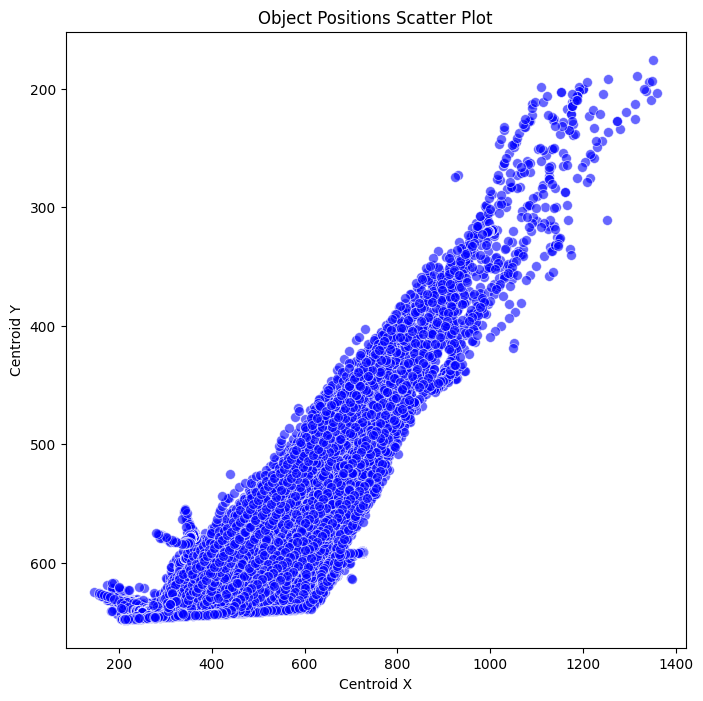

In [ ]:
import seaborn as sns

# Load the CSV data into a DataFrame
data = pd.read_csv(filtered_transformed_output_file)  # Ensure your file name is correct

# Create a scatter plot of object positions
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(
    x='transformed_x',
    y='transformed_y',
    data=data,
    s=50,  # Adjust the size of the dots
    alpha=0.6,  # Adjust the transparency of the dots
    color='blue',
    ax=ax
)
ax.invert_yaxis()
ax.set_title('Object Positions Scatter Plot')
ax.set_xlabel('Centroid X')
ax.set_ylabel('Centroid Y')

# Save the current plot to the PDF
pdf.savefig(fig)
plt.show()
plt.close(fig)


#### Paths Plot

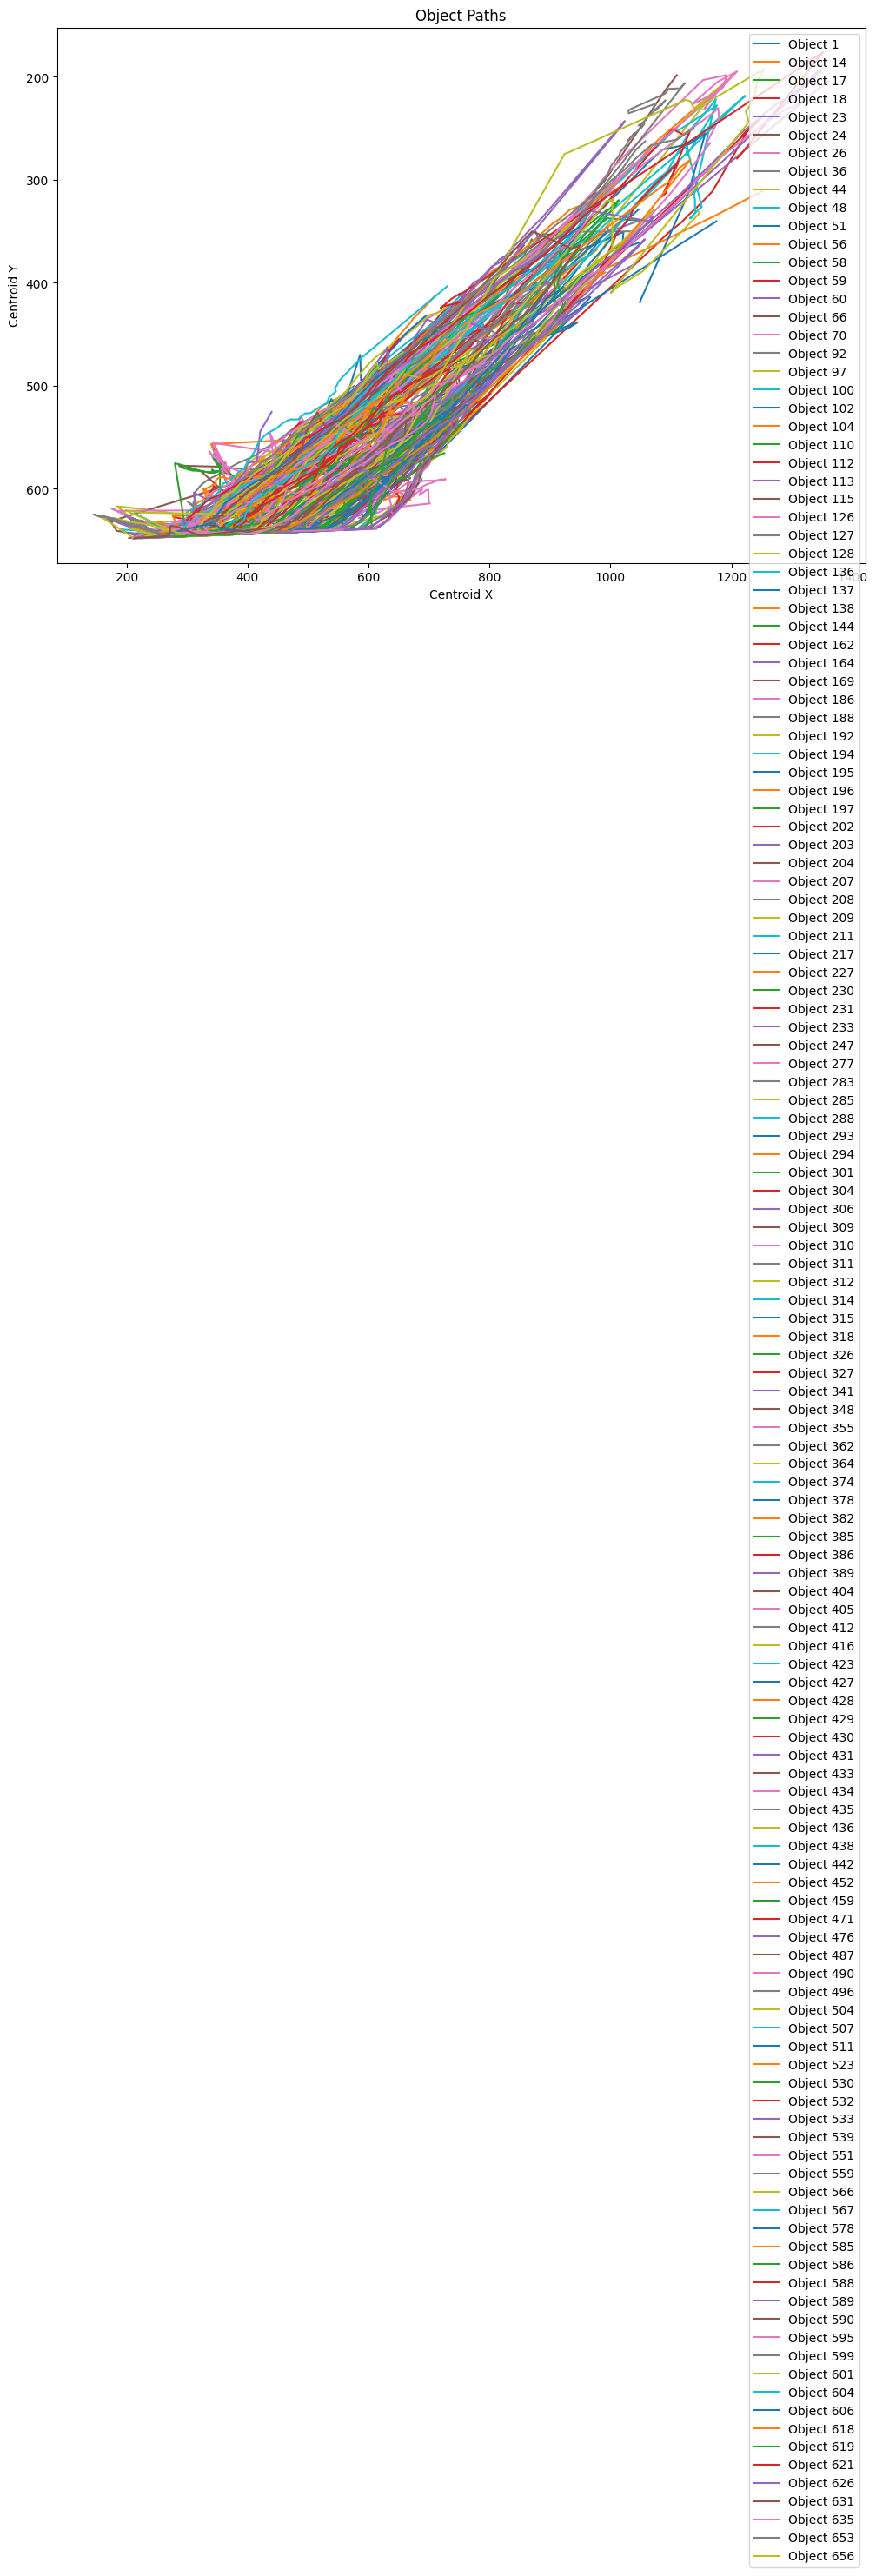

In [ ]:
data = pd.read_csv(filtered_transformed_output_file)  # Ensure your file name is correct


# Group data by object ID
grouped_data = data.groupby('person_id')

# Create a figure for the plot
fig, ax = plt.subplots(figsize=(12, 8))
for object_id, group in grouped_data:
    ax.plot(group['transformed_x'], group['transformed_y'], label=f'Object {object_id}')
ax.invert_yaxis()
ax.set_xlabel('Centroid X')
ax.set_ylabel('Centroid Y')
ax.set_title('Object Paths')
ax.legend()

# Save the current plot to the PDF
pdf.savefig(fig)
plt.show()
plt.close(fig)

In [ ]:
pdf.close()

print(f"All plots have been saved to {pdf_file}")

All plots have been saved to /content/output/2023-06-04_5fps/all_plots.pdf


#### (WIP) Object Density Heatmap Evolution

In [ ]:
import pandas as pd

csv_file = "/content/output/2024-07-29_12_00_5fps_detections.csv"

# Load the CSV data
data = pd.read_csv(csv_file)

# Group data by frame number for a dynamic heatmap
unique_frames = data['frame'].unique()

# Define the name of the video and create a directory with the same name
video_name = 'heatmap_evolution'
os.makedirs(video_name, exist_ok=True)

# Loop through each frame and create a heatmap
for frame in unique_frames:
    # Filter data for the current frame
    frame_data = data[data['frame'] == frame]

    # Create the heatmap
    plt.figure(figsize=(12, 8))
    sns.kdeplot(
        x=frame_data['bottom_mid_x'],
        y=frame_data['bottom_mid_y'],
        fill=True,
        cmap='viridis',
        warn_singular=False
    )

    plt.gca().invert_yaxis()
    # Set plot title and labels
    plt.title(f'Heatmap for Frame {frame}')
    plt.xlabel('Centroid X')
    plt.ylabel('Centroid Y')

    # Save the heatmap image
    plt.savefig(f'/content/heatmap_evolution/heatmap_{frame:04d}.png')
    plt.close()

os.system(f'ffmpeg -r 30 -i {video_name}/heatmap_%04d.png')

256

In [ ]:
!ffmpeg -pattern_type glob -framerate 1 -i '/content/heatmap_evolution/heatmap_*.png' -c:v libx264 -r 30 -pix_fmt yuv420p 'output.mp4'

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab